mmpose install: \
`mmpose_install.ipynb` 파일 \
https://github.com/boostcampaitech3/final-project-level3-cv-13/blob/develop/mmpose_install.ipynb \
을 최상위 폴더에 넣고 실행

freihand dataset download: \
https://github.com/open-mmlab/mmpose/blob/master/docs/en/tasks/2d_hand_keypoint.md#freihand-dataset \
하란 대로 데이터 배치

train과 test에서 config는 \
`mmpose/configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py`를 사용함

train: \
`python tools/train.py configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py`

`ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 80 from PyObject` 에러가 뜰 경우 \
넘파이 업데이트 `pip install --upgrade numpy` 

test: \
이 `test.ipynb` 파일을 `mmpose/tools`에 넣고 실행

train 돌리지 않고 pretrained model 쓰고 싶으면 \
https://mmpose.readthedocs.io/en/latest/topics/hand%282d%29.html#freihand2d-dataset \
에서 `res50_freihand_224x224-ff0799bc_20200914.pth` 다운받아서 \
`mmpose/work_dirs/res50_freihand2d_224x224`에 넣어주고 \
아래 코드에서 `checkpoint_path` 부분 주석처리 해제

In [1]:
import argparse
import os
import os.path as osp
import warnings

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.cnn import fuse_conv_bn
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

from mmpose.apis import multi_gpu_test, single_gpu_test
from mmpose.datasets import build_dataloader, build_dataset
from mmpose.models import build_posenet
from mmpose.utils import setup_multi_processes

In [26]:
# cfg
cfg = Config.fromfile('../configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/freihand2d/res50_freihand2d_224x224.py')

# test.test_mode = True
cfg.model.pretrained = None
cfg.data.test.test_mode = True

# work_dir
cfg.work_dir = '../work_dirs'

# dataset = build_dataset

# test.py는 mmpose 디렉토리에서 python tools/test.py를 이용해 돌리지만
# 이 test.ipynb 파일은 mmpose/tools 디렉토리에서 돌리기 때문
cfg.data.test.ann_file = '../data/freihand/annotations/freihand_test.json'
cfg.data.test.img_prefix = '../data/freihand/'
# cfg.data.test

dataset = build_dataset(cfg.data.test, dict(test_mode=True))
# dataset
# next(iter(dataset))

"""
# 그냥 궁금해서 train dataset 구조 확인
cfg.data.train.ann_file = '../data/freihand/annotations/freihand_train.json'
cfg.data.train.img_prefix = '../data/freihand/'
dataset = build_dataset(cfg.data.train)
# dataset
next(iter(dataset))
"""

# 'distributed=True' means multi gpu setup
data_loader = build_dataloader(dataset, samples_per_gpu=1, workers_per_gpu=1, dist=False, shuffle=False)

model = build_posenet(cfg.model)

checkpoint_path = '../work_dirs/res50_freihand2d_224x224/best_AUC_epoch_30_20220523.pth'
# checkpoint_path = '../work_dirs/res50_freihand2d_224x224/res50_freihand_224x224-ff0799bc_20200914.pth'

load_checkpoint(model, checkpoint_path, map_location='cpu')

model = MMDataParallel(model.cuda(), device_ids=[0])
outputs = single_gpu_test(model, data_loader)

loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
=> num_images: 13024
=> load 13024 samples
load checkpoint from local path: ../work_dirs/res50_freihand2d_224x224/best_AUC_epoch_30_20220523.pth
[                              ] 8/13024, 23.1 task/s, elapsed: 0s, ETA:   564s

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[>>>>>>>>>>>>>>>>>>>>>>>>] 13024/13024, 44.7 task/s, elapsed: 291s, ETA:     0s

In [95]:
outputs[0]

{'preds': array([[[ 74.399994  , 106.399994  ,   0.8807707 ],
         [ 95.2       , 104.8       ,   0.91339046],
         [111.20001   ,  98.399994  ,   0.86297387],
         [124.        ,  95.2       ,   0.8780872 ],
         [140.        ,  87.2       ,   0.8909603 ],
         [125.600006  , 101.600006  ,   0.89170486],
         [138.4       , 108.        ,   0.877851  ],
         [149.6       , 117.600006  ,   0.83270675],
         [160.8       , 127.20001   ,   0.8592646 ],
         [122.399994  , 108.        ,   0.86917895],
         [138.4       , 117.600006  ,   0.890458  ],
         [146.4       , 127.20001   ,   0.9384484 ],
         [160.8       , 136.8       ,   0.91080725],
         [112.8       , 114.399994  ,   0.88933194],
         [127.20001   , 120.8       ,   0.89630747],
         [136.8       , 130.4       ,   0.89591926],
         [149.6       , 140.        ,   0.8441979 ],
         [103.20001   , 122.399994  ,   0.9207518 ],
         [111.20001   , 127.20001   ,

6788


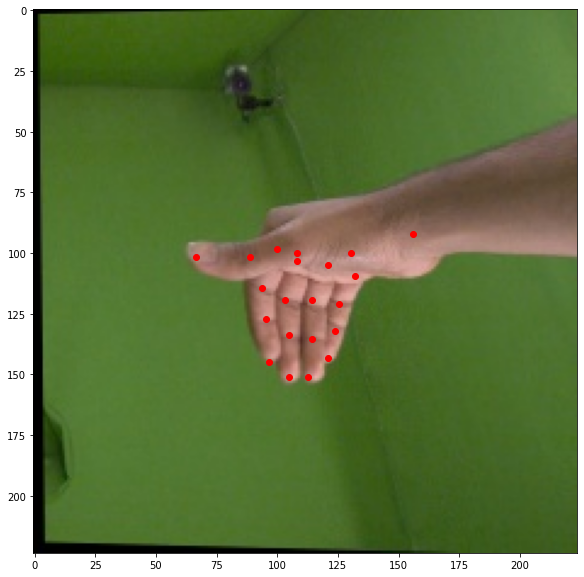

In [181]:
import matplotlib.pyplot as plt
# import cv2
import matplotlib as mpl
import numpy as np
import os

i = np.random.randint(0, len(outputs))
print(i)

output = outputs[i]
img_path = output['image_paths'][0]

# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = mpl.image.imread(img_path)

fig, ax = plt.subplots(figsize=(10,10))

kp = []
for hand in output['preds']:
    l = []
    for keypoint in hand:
        x = keypoint[0]
        y = keypoint[1]
        l.append((x, y))
    kp.append(l)
        
for hand in kp:
    for keypoint in hand:
        ax.scatter(keypoint[0], keypoint[1], color='red')

plt.imshow(img)
plt.show()